# **Case 3**: Fitting gravity acceleration from points over an eccentric orbit

In [3]:
import os
import numpy as np
import pyshtools as sh
import matplotlib.pyplot as plt

import spherical_inr as sph
import spherical_inr.differentiation as D
import torch
import math

import scripts
from scripts._units import *

## Settings

In [4]:
out_name = "eccentric_trajectory" # outputs destination folder (a subfolder of out)
out_path = os.path.join("out", out_name)
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [5]:
partials_func = scripts.pot_cnm_partials 
rng = np.random.default_rng()

### Ground-truth gravity
As in the previous notebook, we select as ground-truth the gravity coefficients of Mars, as estimated by Konopliv, et al. (2016), and available on the [NASA PDS](https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/mrors_1xxx/data/shadr/). 

In [5]:
L_gt = 120 # macimum degree of the coefficients used to simulate the measurements
L_est = 100 # maximum degree of the coefficients to be estimated

# Read SH coefficients, and cut to L_gt
file_name = "spice/data/jgmro_120d_sha.tab"
coeffs, r_0, gm = scripts.read_SHADR(file_name)
cnm_gt = coeffs[:, : L_gt + 1, : L_gt + 1]

# Index array and dictionary to go from a matrix of Cnm to a 1D array, and vice-versa
cnm_idx_sim, cnm_map_sim = scripts.get_cnm_idx(L_gt)
cnm_idx_est, cnm_map_est = scripts.get_cnm_idx(L_est)

## Forward

### Measurements schedule
This section is used to pick measurement points among those describing a trajctory. The choice of the measurement time-tags is inspired by tracking schedules for radio-tracking observations. For example, we can select to pick 4 hours (`pass_length`) of contiguous points, 60-s apart from each other (`dt`), once every day (`passes_per_day=1`) and at random times during each day (`random_track_start=True`). All this over 1 Earth year (`t_span`).

In [ ]:
t_vec = scripts.measurement_schedule(
        t_span=365 * day, dt = 60.* sec, passes_per_day=1, pass_length=4 * hour, random_track_start=True, rng=rng
    )
n_msr_pts = t_vec.shape[0]
print("{:d} measurements selected over {:.2f} days".format(n_msr_pts, t_vec[-1]/day))    

100%|██████████| 365/365 [00:00<00:00, 103189.60it/s]

87600 measurements selected over 364.42 days


### Training & Testing Data

In [ ]:
e_mex = 0.57
r_p_mex = 234*km+r_0 # 298 km before ? 
a_mex = r_p_mex/(1-e_mex)


xyz_coords_train, sph_coords_train, t_vec = scripts.points_from_keplerian_traj(
    gm,
    t_vec,  
    coverage=1.0, 
    elts=dict(
        a=a_mex, i=92.6 * deg, e=e_mex, om=270 * deg, Om=0.0 * deg, M_0=0.0 * deg
    ),
)

xyz_coords_test, sph_coords_test = scripts.points_from_grid(L_gt, r=(r_0 * 1.1), use_GLQ_grid=True)

In [ ]:
pot_train, acc_train = [
    el * gm for el in scripts.compute_pot_acc(cnm_gt, r_0, sph_coords_train)
]

100%|██████████| 121/121 [23:59<00:00, 11.89s/it] 


In [ ]:
pot_test, acc_test = [
    el * gm for el in scripts.compute_pot_acc(cnm_gt, r_0, sph_coords_test)
]

100%|██████████| 121/121 [00:36<00:00,  3.30it/s]


### Storing results

In [ ]:
# Saving measurements evaluated on a spherical grid
grid_train_file = "acc_train"
scripts.save_msr_grid(
    os.path.join(out_path, grid_train_file + ".pkl"),
    sph_coords_train,
    acc_train,
)

grid_pot_train_file = "pot_train"
scripts.save_msr_grid(
    os.path.join(out_path, grid_pot_train_file + ".pkl"),
    sph_coords_train,
    pot_train,
)

grid_gt_file = "pot_test"
scripts.save_msr_grid(
    os.path.join(out_path, grid_gt_file + ".pkl"),
    sph_coords_test,
    pot_test,
)

## Retrieve

In [6]:
grid_train_file = "acc_train"
sph_coords_train, acc_train = scripts.read_msr_grid(
    os.path.join(out_path, grid_train_file + ".pkl")
)

grid_pot_train_file = "pot_train"
_, pot_train = scripts.read_msr_grid(
    os.path.join(out_path, grid_pot_train_file + ".pkl")
)

grid_gt_file = "pot_test"
sph_coords_test, pot_test = scripts.read_msr_grid(
    os.path.join(out_path, grid_gt_file + ".pkl")
)


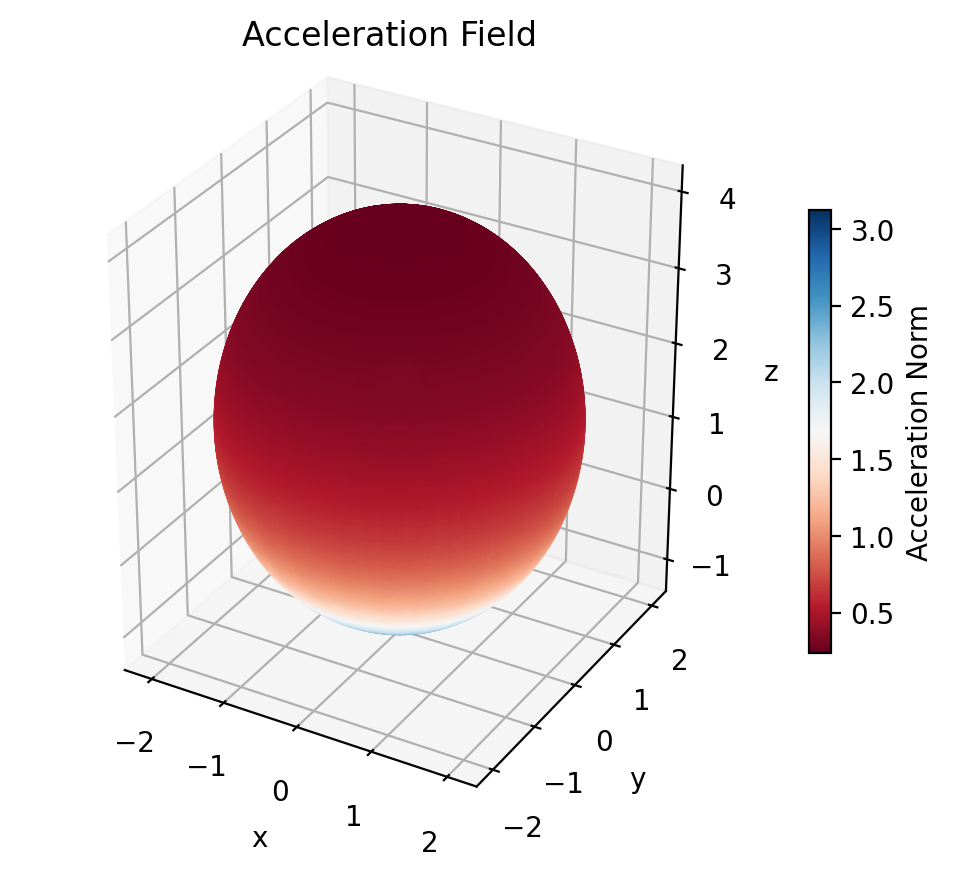

In [7]:
r   = sph_coords_train[:, 0]
th  = sph_coords_train[:, 1]  # colatitude in radians
phi = sph_coords_train[:, 2]

x = r * np.sin(th) * np.cos(phi)
y = r * np.sin(th) * np.sin(phi)
z = r * np.cos(th)


fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    x / r_0,
    y / r_0,
    z / r_0,
    c=np.linalg.norm(acc_train, axis=-1),
    cmap="RdBu"
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_aspect('equal')
plt.title("Acceleration Field")

cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Acceleration Norm")


plt.show()

## HNET

In [8]:
model_path = os.path.join("models", out_name)
if not os.path.exists(model_path):
    os.makedirs(model_path)

### Data Preprocessing

We define some reference value for the radius, potential and acceleration to later un-dimensionalize them. 

In [9]:
r_star =(r_0 + 234.0 * km)
u_star = gm / r_star
a_star = u_star / r_star

print(
    f"u_star = {u_star} [m^2/s^2]",
    f"r_star = {r_star} [m]",
    f"a_star = {a_star} [m/s^2]",
    sep="\n"
)

u_star = 11798450.63794934 [m^2/s^2]
r_star = 3630000.0 [m]
a_star = 3.2502618837326005 [m/s^2]


Deep Learning model needs to work with scaled data

In [10]:
pot_train_scaled = pot_train.copy().reshape(-1, 1) / u_star
acc_train_scaled = acc_train.copy() / a_star

pot_test_scaled = pot_test.copy().reshape(-1, 1) / u_star

sph_coords_train_scaled = sph_coords_train.copy()
sph_coords_train_scaled[:, 0] /= r_star

sph_coords_test_scaled = sph_coords_test.copy()
sph_coords_test_scaled[:, 0] /= r_star

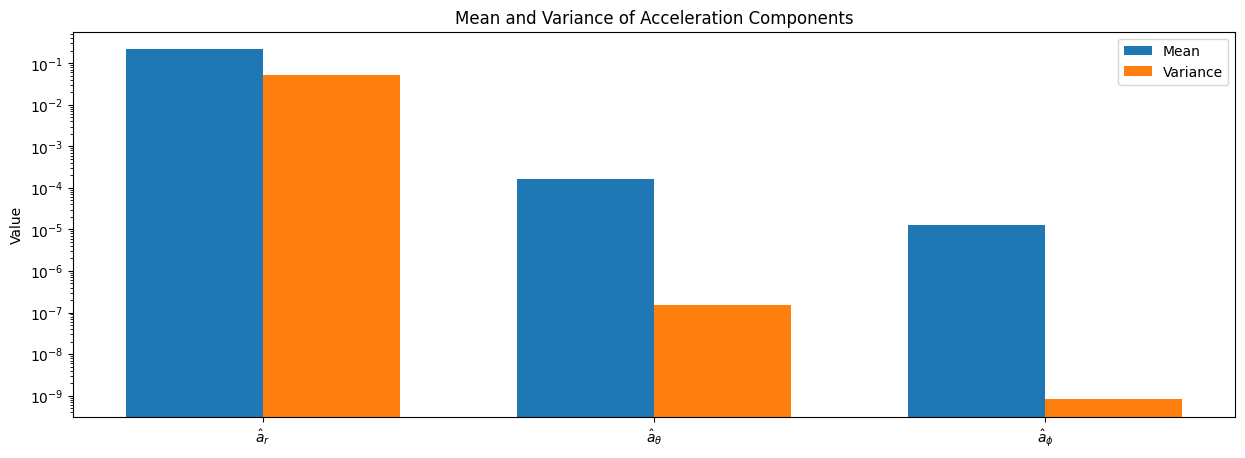

In [11]:
# Compute mean and variance for each component of the acceleration (spherical frame)
mean_vals = np.mean(np.abs(acc_train_scaled), axis=0)
var_vals = np.var(acc_train_scaled, axis=0)
labels_acc = [r'$\hat{a}_{r}$', r'$\hat{a}_{\theta}$', r'$\hat{a}_{\phi}$']

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))


x = np.arange(len(labels_acc))
width = 0.35  # width of the bars

ax1.bar(x - width/2, mean_vals, width, label='Mean')
ax1.bar(x + width/2, var_vals, width, label='Variance')
ax1.set_ylabel('Value')
ax1.set_title('Mean and Variance of Acceleration Components')
ax1.set_xticks(x)
ax1.set_xticklabels(labels_acc)
ax1.legend()
ax1.set_yscale('log')

plt.show()

In [12]:
xtrain = torch.tensor(sph_coords_train_scaled.copy(), dtype=torch.float32).requires_grad_(True)
ytrain = torch.tensor(acc_train_scaled.copy(), dtype=torch.float32)
ytrain_pot = torch.tensor(pot_train_scaled.copy(), dtype=torch.float32)

xtest = torch.tensor(sph_coords_test_scaled.copy(), dtype=torch.float32)
ytest = torch.tensor(pot_test_scaled.copy(), dtype=torch.float32)

### Model

In [2]:
hnet = scripts.GravityHNet(
    inr_sizes=[15] + 3*[100],
    activation="relu",
)

NameError: name 'scripts' is not defined

In [105]:
hnet.pe.euler_angles.data = torch.randn((hnet.pe.num_atoms, 3)) * math.pi
hnet.pe.w_R = hnet.pe.w_R.requires_grad_(False)
hnet.pe.rref = hnet.pe.rref.requires_grad_(False)

In [107]:
def forward_pe_no_rot(x):

    x = hnet.to_cart(x)
    x = x.to(hnet.pe.A.dtype)

    r = torch.norm(x, dim=-1, keepdim=True, p = 2)
    ax = torch.matmul(x, hnet.pe.A.t())

    ax_R = ax.real
    ax_I = ax.imag
    sin_term = torch.sin(hnet.pe.w_R * ((ax_I / r) *  (hnet.pe.rref/r)) + hnet.pe.b_I)
    exp_term = torch.exp(hnet.pe.w_R * ( (ax_R / r) * (hnet.pe.rref/r) - 1/math.sqrt(2.)))

    return  (1/r) * exp_term * sin_term 


### Atoms

In [108]:
atoms =  hnet.forward_pe(xtest).detach().numpy()
atoms_no_rot = forward_pe_no_rot(xtest).detach().numpy()

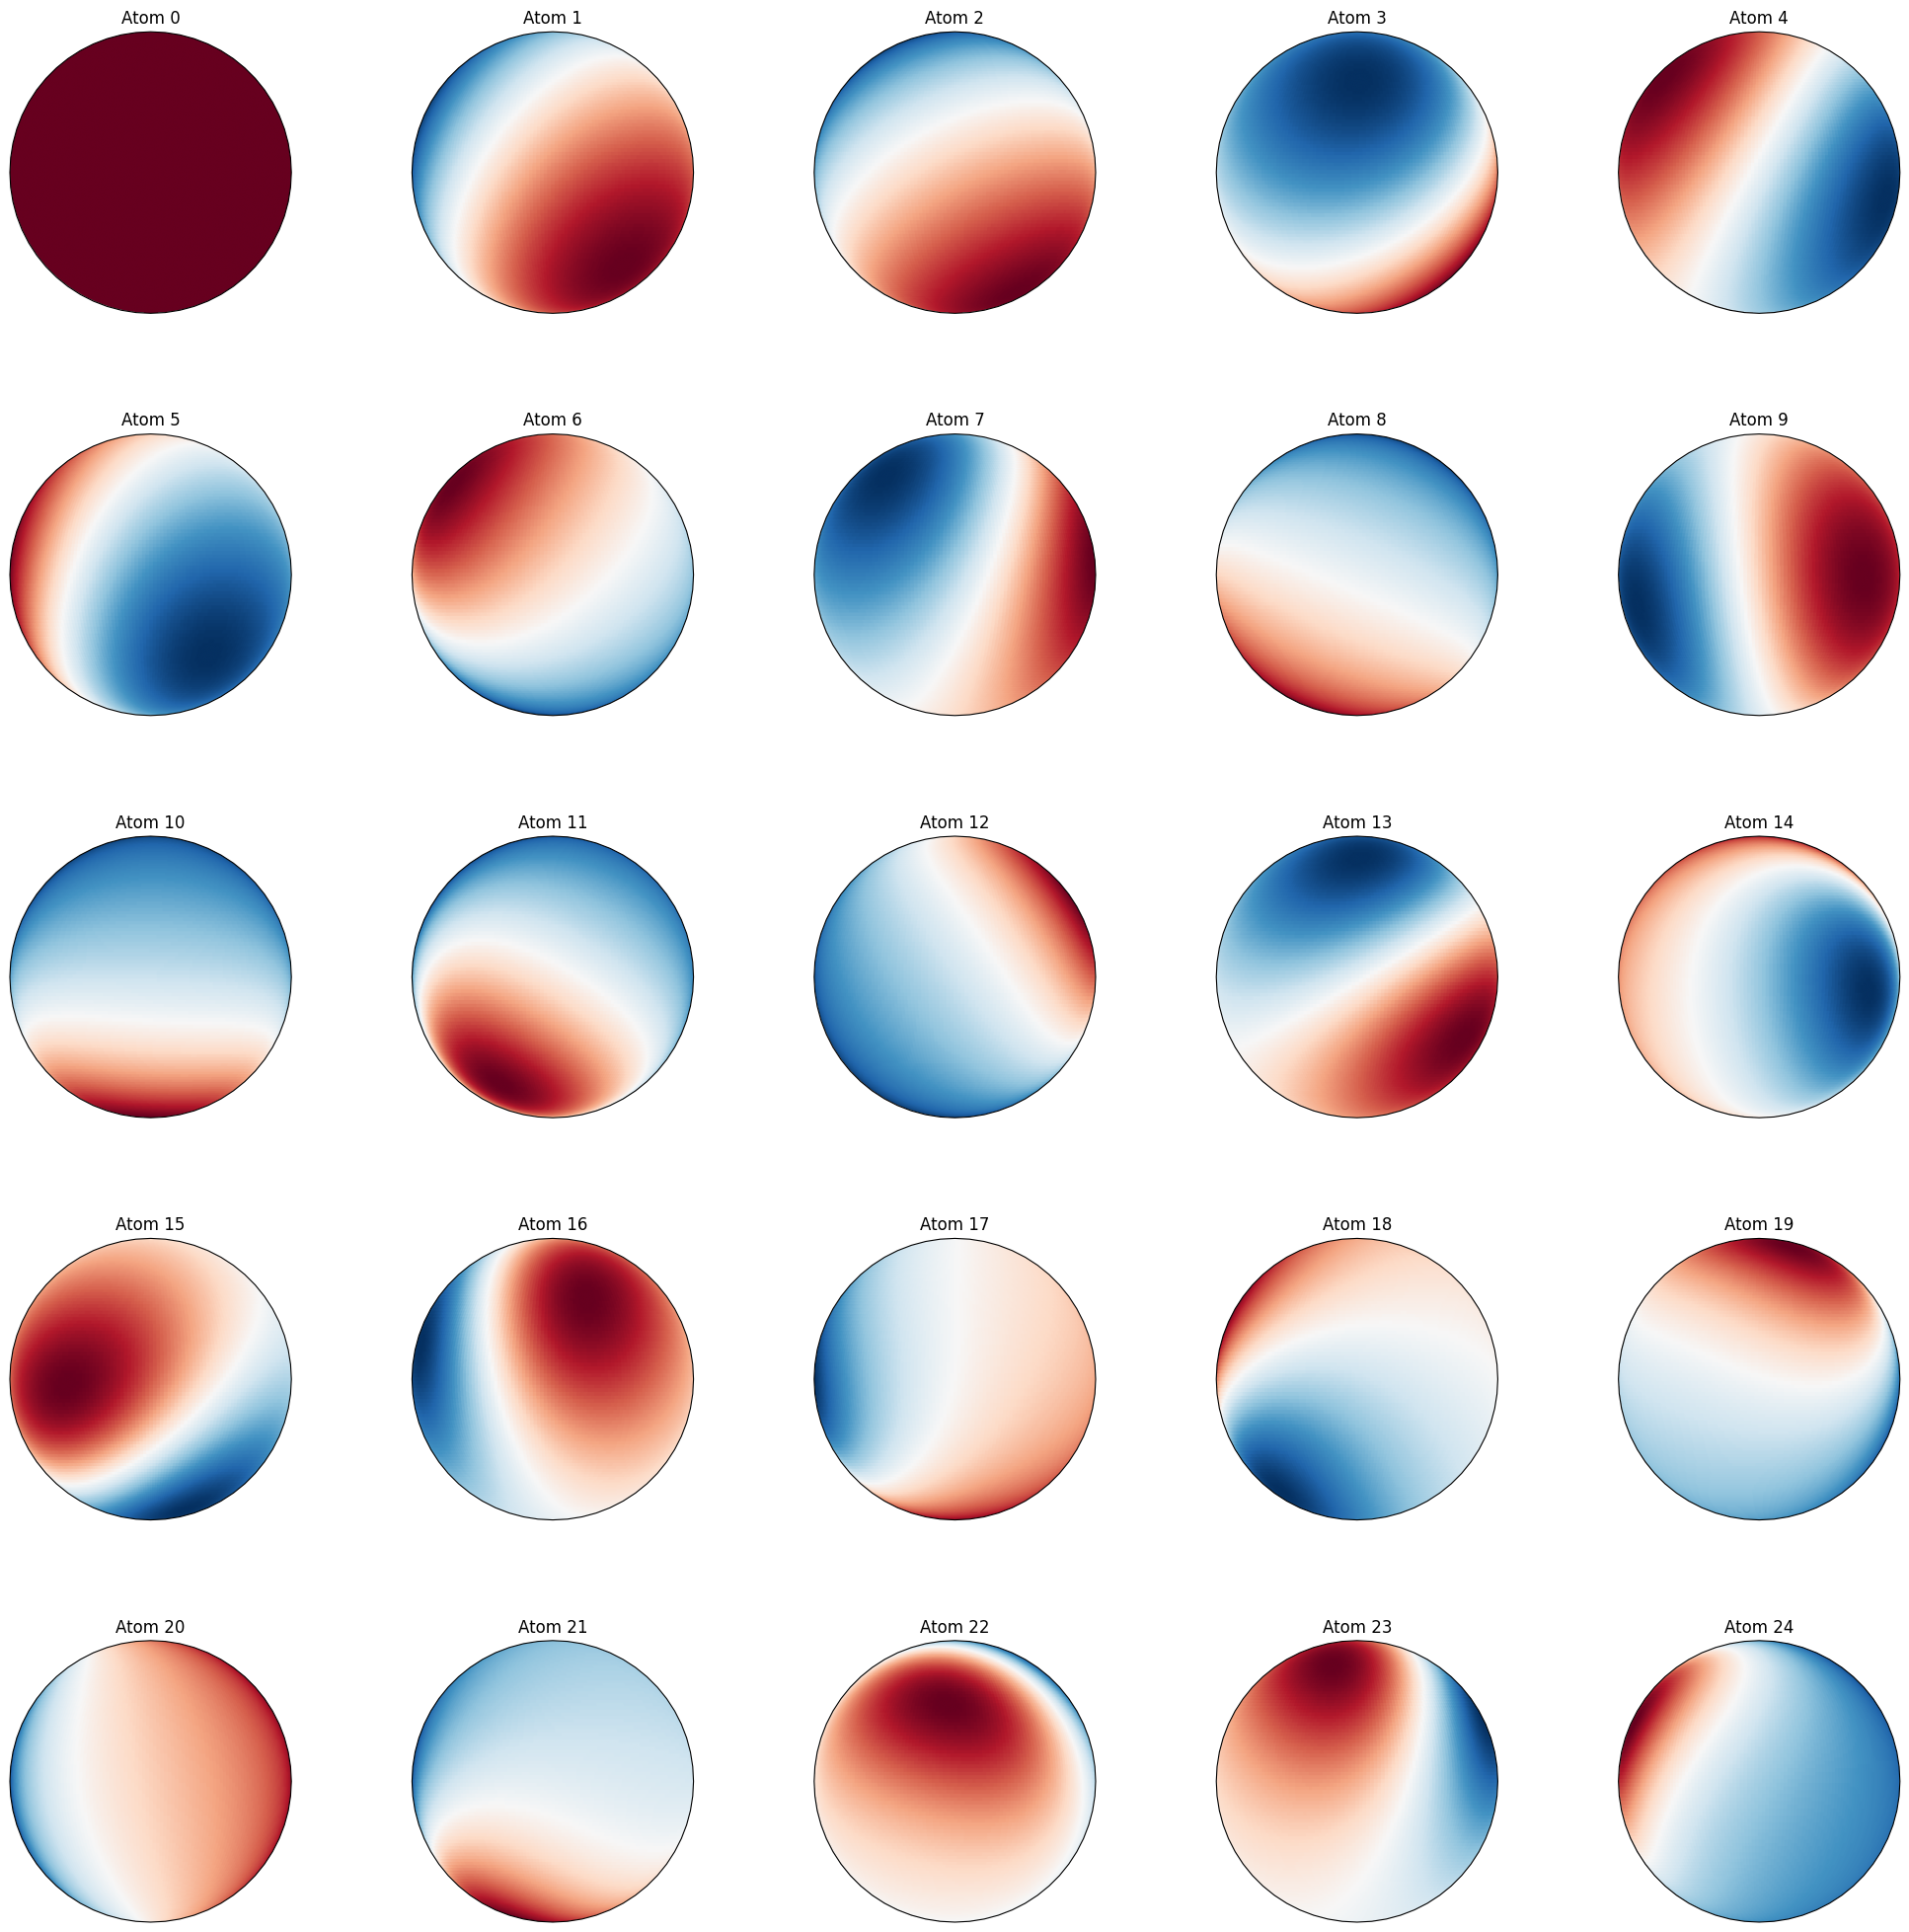

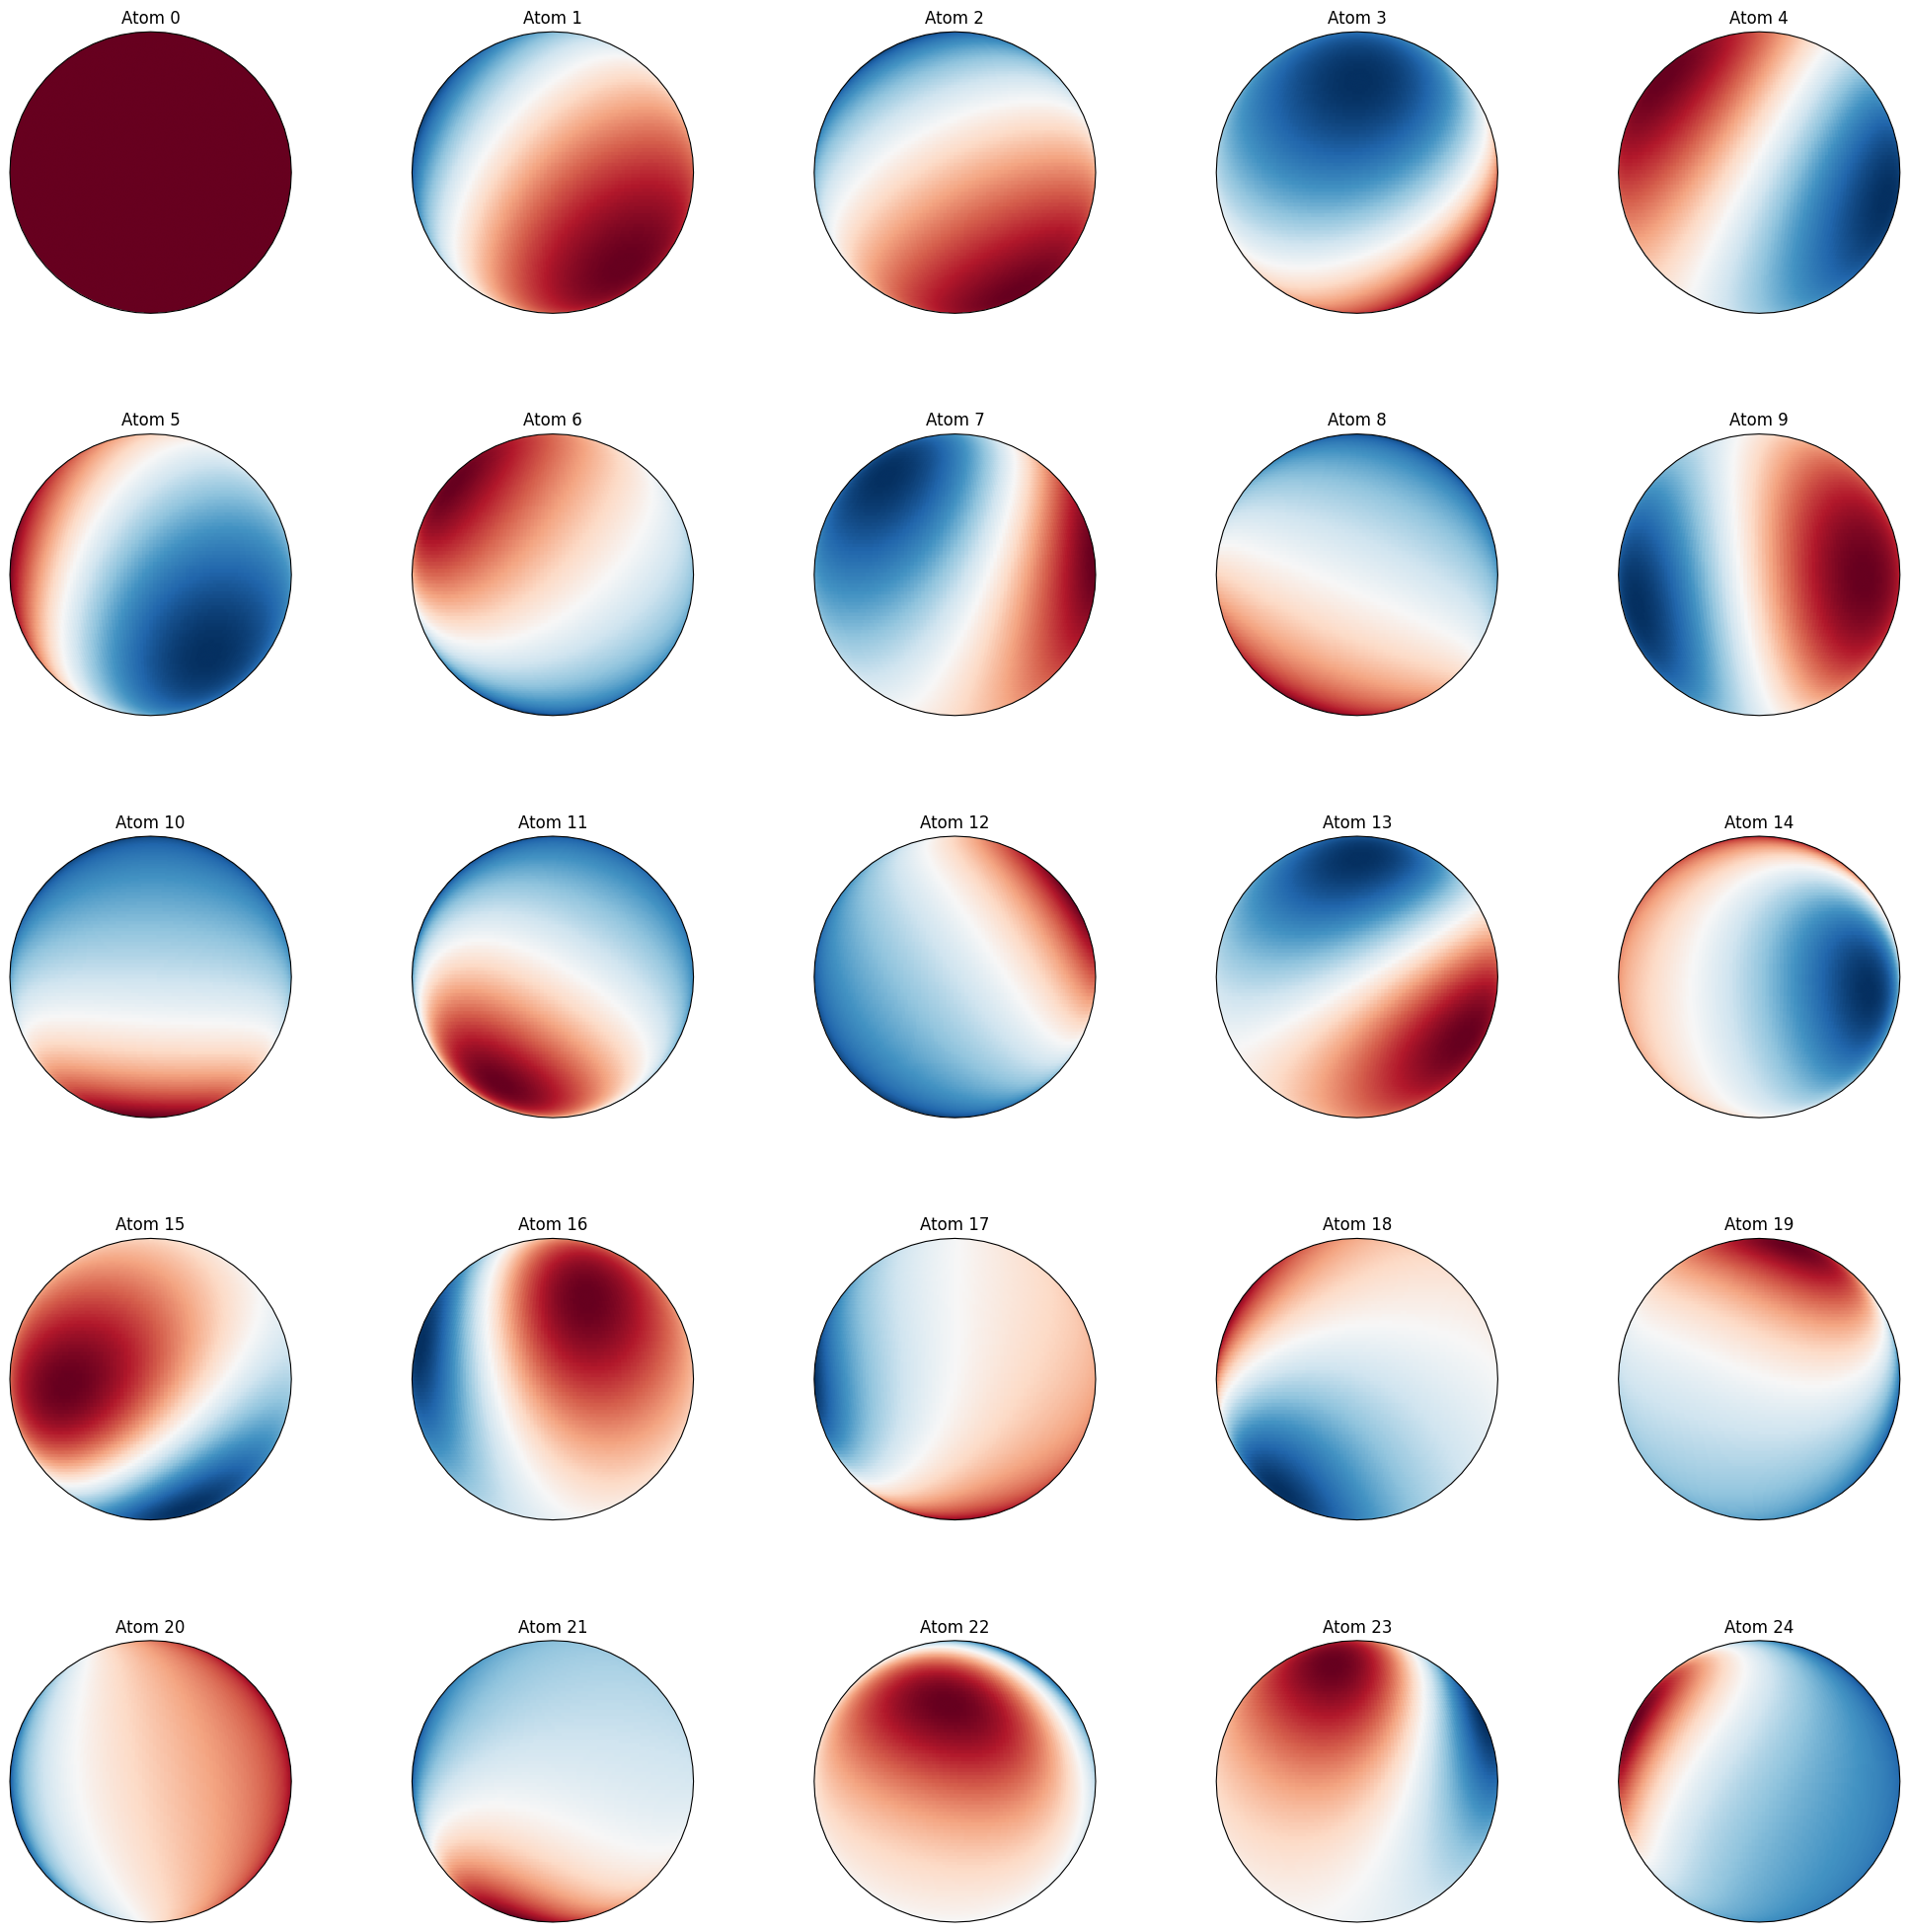

In [109]:
fig = plt.figure(figsize = (20, 20), dpi=100, )
subfigs = fig.subfigures(5, 5, wspace=0.1, hspace=0.1)

for i, sb in enumerate(subfigs.flat[:25]) :
    _, ax = scripts.plot_s2(atoms[..., i].reshape(L_gt+1, 2*(L_gt+1) - 1),fig= sb, cmap = "RdBu", projection=True)
    ax.set_title(f"Atom {i}")

plt.show()

fig = plt.figure(figsize = (20, 20), dpi=100, )
subfigs = fig.subfigures(5, 5, wspace=0.1, hspace=0.1)

for i, sb in enumerate(subfigs.flat[:25]) :
    _, ax = scripts.plot_s2(atoms_no_rot[..., i].reshape(L_gt+1, 2*(L_gt+1) - 1),fig= sb, cmap = "RdBu", projection=True)
    ax.set_title(f"Atom {i}")

plt.show()


### Training

In [ ]:
scripts.train(
    hnet,
    optimizer=torch.optim.Adam(hnet.parameters(), lr=1e-2),
    epoch=500,
    N_reg=1000,
    batch_size=4096,
    data_train=(xtrain, ytrain),
    data_val=(xtest, ytest),   
    save_path = model_path,  
    reg_fn=scripts.flux_regulizer,
    sample_fn=scripts.two_sphere_sample,
    beta_reg=1e-3
)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110ebd010>>
Traceback (most recent call last):
  File "/Users/theohanon/Desktop/GravityHerglotzNet/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [1]:
hnet.load_state_dict(torch.load(model_path + "/best_model.pth"))
hnet.eval()

NameError: name 'hnet' is not defined

In [86]:
def U(x):
    return u_star * (hnet(x).squeeze().detach().numpy())

In [87]:
r_inf=1e12
U_inf = U(torch.tensor([[r_inf, 0, 0]], dtype=torch.float64))
print(f"U_inf = {U_inf}")

U_inf = 1.180016982294641e-05


### Errors

In [88]:
xtest_g = xtest.clone().requires_grad_(True)
pot_pred_g = hnet(xtest_g)
grad = D.spherical_gradient(pot_pred_g, xtest_g).norm(dim=-1).detach().numpy()
pot_pred = U(xtest)

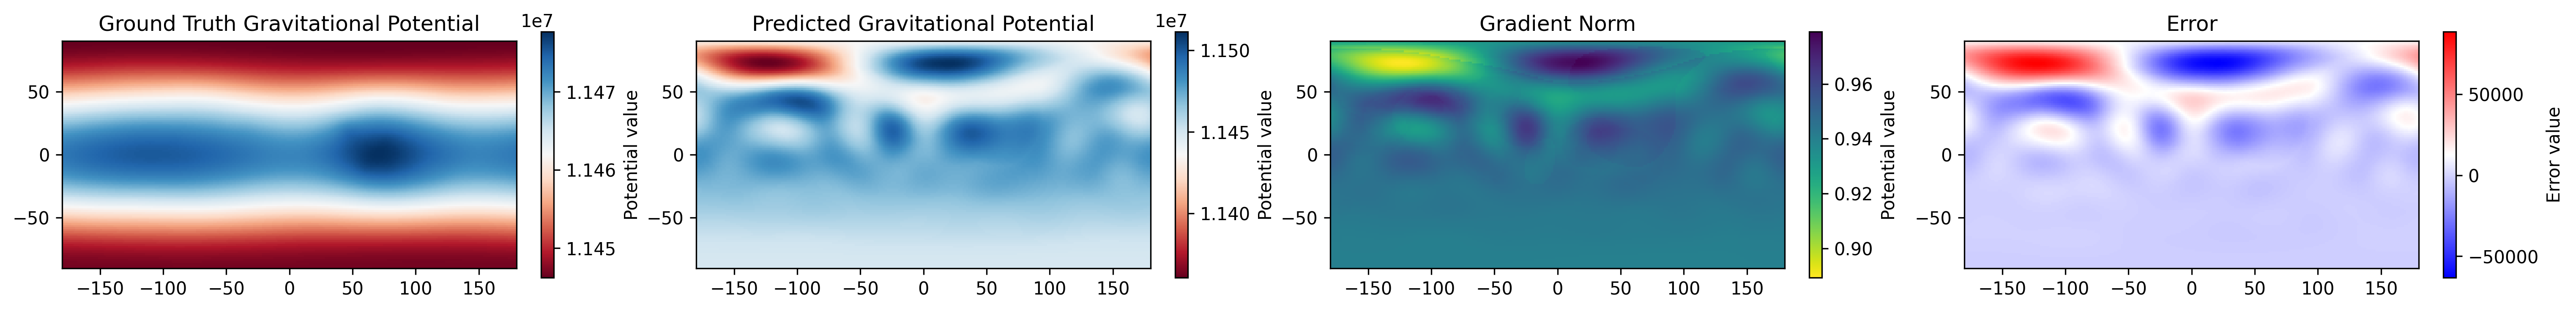

In [89]:
data_pred = pot_pred.reshape((L_gt+1, 2*(L_gt+1) - 1))
data_test = pot_test.reshape( (L_gt+1, 2*(L_gt+1) - 1))
grad_norm = grad.reshape( (L_gt+1, 2*(L_gt+1) - 1))

fig = plt.figure(figsize=(20, 15), dpi = 300)
subfigs = fig.subfigures(1, 4)
_, ax = scripts.plot_s2(data_test,   fig= subfigs[0], cmap = "RdBu")
ax.set_title("Ground Truth Gravitational Potential")
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

_, ax = scripts.plot_s2(data_pred,   fig= subfigs[1], cmap = "RdBu")
ax.set_title("Predicted Gravitational Potential")
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

_, ax = scripts.plot_s2(grad_norm,   fig= subfigs[2], cmap = "viridis_r")
ax.set_title("Gradient Norm")
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

_, ax = scripts.plot_s2(data_test - data_pred,   fig= subfigs[3], cmap = "bwr")
ax.set_title("Error")
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Error value')

plt.show()

In [62]:
errors = (pot_test - pot_pred)
rel_errors = errors / pot_test

error_stats = [
    np.mean(errors),
    np.median(errors),
    np.var(errors),
    np.linalg.norm(errors) / np.sqrt(errors.size),
]
error_stats.append(np.log10(np.abs(np.mean(1 / (rel_errors + 1e-20)))))

print("Error stats: ")
print("Mean: {:.5g} - Median: {:.5g} -  Var : {:5g} - RMS: {:.5g} - SNR (dB):{:.5g}".format(*error_stats))

Error stats: 
Mean: 422.7 - Median: 260.59 -  Var : 228114 - RMS: 637.8 - SNR (dB):4.1716
